### 混合モデル（p.94）

In [53]:
%matplotlib inline
from scipy.stats import poisson, uniform, expon
from IPython.core.pylabtools import figsize
import numpy as np

import matplotlib.pyplot as plt

(array([  3.,   2.,   6.,   9.,  15.,  17.,  15.,  19.,  12.,  16.,  15.,
         31.,  32.,  40.,  31.,  24.,  10.,   2.,   0.,   1.]),
 array([  47.40688607,   58.916721  ,   70.42655594,   81.93639088,
          93.44622581,  104.95606075,  116.46589569,  127.97573062,
         139.48556556,  150.99540049,  162.50523543,  174.01507037,
         185.5249053 ,  197.03474024,  208.54457518,  220.05441011,
         231.56424505,  243.07407999,  254.58391492,  266.09374986,
         277.60358479]),
 <a list of 1 Patch objects>)

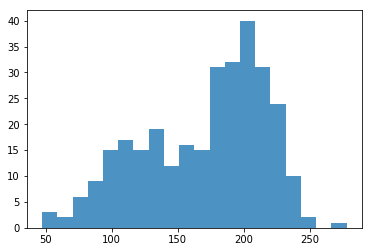

In [58]:
data = np.loadtxt("data/mixture_data.csv", delimiter=",")
plt.hist(data, bins=20, histtype="stepfilled", alpha=0.8)

In [155]:
import pymc as pm

p = pm.Uniform("p", 0., 1.)
pi = pm.Categorical("pi", [p, 1 - p], size=data.shape[0])  # クラスタの所属確率
# 各クラスタは正規分布に従うと仮定
taus = 1.0 / pm.Uniform("stds", 0, 100, size=2) ** 2  # 正規分布の標準偏差の事前確率
mus = pm.Normal("mus", [120, 190], [0.01, 0.01], size=2)  # 正規分布の平均の事前確率

@pm.deterministic
def mu_i(pi=pi, mus=mus):
    return mus[pi]

@pm.deterministic
def tau_i(pi=pi, taus=taus):
    return taus[pi]

# --------  事前分布 -------------------#
print(pi.value[:4])  # 先頭４つのデータに関するランダムなクラスタ割り当て
print(mus.value)  # ２つのクラスタの分布の平均
print(taus.value)  # ２つのクラスタの分布の精度
# --------  モデリング-------------------#
obs = pm.Normal("obs", mu_i, tau_i, value=data, observed=True)
model = pm.Model([p, pi, taus, mus])
mcmc = pm.MCMC(model)
mcmc.sample(50000)

[0 0 1 1]
[ 111.36975819  187.16023713]
[ 0.00010387  0.00036934]
 [-----------------100%-----------------] 50000 of 50000 complete in 12.5 sec

In [156]:
# --------  事後分布 -------------------#
pi_samples = mcmc.trace('pi')[:]
print(pi_samples[-1,:4])  # 最後のサンプリングでの先頭４つのデータに関する所属クラスタ
mus_samples = mcmc.trace('mus')[:]
print(np.mean(mus_samples, axis=0))  # ２つのクラスタの平均に関する事後分布の期待値
stds_samples = mcmc.trace('stds')[:]
print(np.mean(stds_samples, axis=0))  # ２つのクラスタの精度に関する事後分布の期待値

[0 1 1 1]
[ 122.3319494   198.38575351]
[ 32.85138562  24.08100188]


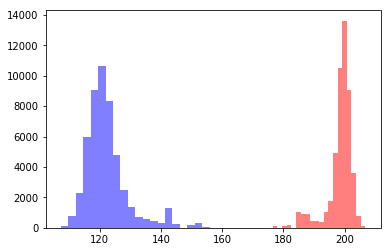

In [157]:
colors = ["blue", "red"]

# クラスタの平均の分布
for i in range(2):
    plt.hist(mus_samples[:, i], color=colors[i], alpha=0.5, bins=20)

(35, 300)

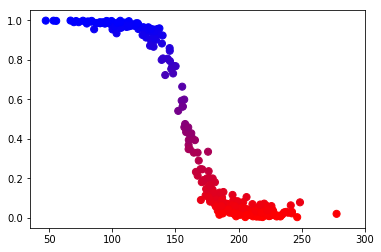

In [158]:
import matplotlib as mpl
# クラスタの所属確率
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
pi_samples = mcmc.trace("pi")[:]

plt.scatter(data, 1 - pi_samples.mean(axis=0), cmap=cmap,
        c=pi_samples.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)

Plotting mus_0
Plotting mus_1


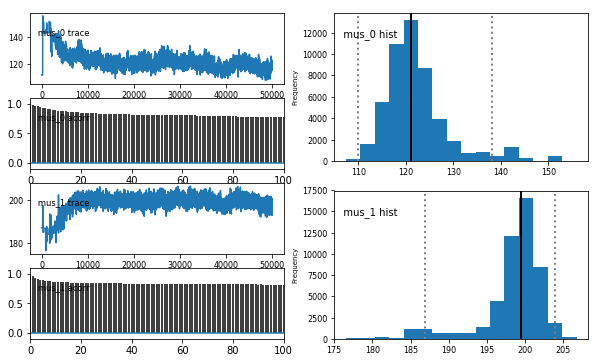

In [160]:
from pymc.Matplot import plot as mcplot

mcplot(mcmc.trace('mus'), common_scale=False)